In [1]:
import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, average_precision_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.metrics import roc_auc_score, precision_recall_curve

from sklearn.pipeline import FeatureUnion
from sklearn.metrics import confusion_matrix
from functools import partial
from src.features.url_classification import classifier_LICA, classifier_DFR
import more_itertools as mit
from urllib.parse import urlparse
from sklearn.metrics.pairwise import cosine_similarity
import lightgbm as lgb

import tensorflow as tf
import tensorflow_hub as hub
import keras.layers as layers
from keras.models import Model
from keras import backend as K
np.random.seed(10)

W0605 15:51:19.807505 140329940543040 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14
Using TensorFlow backend.


In [2]:
from skopt import BayesSearchCV

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

In [5]:
DIR = '../../data/processed'
crawls = glob.glob('{}/media_2019*.csv'.format(DIR))
last_crawl = sorted(crawls)[-1]
df_snopes = pd.read_csv(last_crawl)
df_snopes = df_snopes[df_snopes.label!='mixture']

In [109]:
df_snopes.legal_page_urls = df_snopes.legal_page_urls.apply(lambda x: [y.strip(' \'"') for y in str(x)[1:-1].split(',')])

In [112]:
df_snopes[df_snopes.url_caption == 'tesla-car-really-space'].legal_page_urls.loc[152]

['https://www.theguardian.com/science/2018/feb/07/space-oddity-elon-musk-spacex-car-mars-falcon-heavy',
 'https://www.popularmechanics.com/space/rockets/a24672235/spacex-starman-mars-orbit/',
 'https://www.houstonchronicle.com/business/technology/article/SpaceX-success-gives-Texans-reason-to-cheer-12584146.php',
 'https://www.cbc.ca/news/technology/spacex-starman-1.4524624',
 'https://www.nytimes.com/2018/02/07/briefing/winter-olympics-spacex-steve-wynn.html',
 'https://tucson.com/news/national/the-groundbreaking-spacex-falcon-heavy-launch-in-photos/collection_b60b8c37-aef8-5f5c-a259-1533c5ba9901.html',
 'https://www.latimes.com/business/la-fi-tesla-spacex-buyout-20180809-story.html',
 'http://www.news-journalonline.com/news/20180206/spacexs-big-new-rocket-blasts-off-with-sports-car-on-top/1',
 'https://www.recorder.com/Space-sports-car-now-flying-toward-asteroid-belt-beyond-Mars-15407986',
 'https://www.nzherald.co.nz/business/news/article.cfm?c_id=3&objectid=11989902',
 'https://www.

In [113]:
df_snopes['url_categories_dfr'] = df_snopes.legal_page_urls.apply(lambda x: list(mit.flatten([dfr_clf.classify(y) for y in x])))

In [125]:
from collections import Counter

In [144]:
Counter([str(list(dfr_clf.classify(y))) for y in df_snopes[df_snopes.url_caption == 'tesla-car-really-space'].legal_page_urls.loc[152]])

Counter({"['sports', 'general']": 4,
         "['technology & computing', 'general']": 3,
         "['uncategorized', 'no consensus']": 13,
         "['society', 'general']": 4,
         "['uncategorized', 'unknown']": 12,
         "['arts & entertainment', 'general']": 6,
         "['science', 'general']": 3,
         "['business', 'general']": 2,
         "['automotive', 'general']": 1,
         "['business', 'marketing']": 1})

In [6]:
df_snopes[df_snopes.claim.str.contains('video',regex=False, case=False)].label.value_counts()

false    109
true      22
Name: label, dtype: int64

In [7]:
df_snopes = df_snopes[~df_snopes.claim.str.contains('video',regex=False, case=False)]

In [8]:
crawls = glob.glob('{}/reuters/media_*.csv'.format(DIR))
last_crawl = sorted(crawls)[-1]
df_reuters = pd.read_csv(last_crawl)
df_reuters.label = 'true'

In [9]:
df_snopes.shape, df_reuters.shape

((838, 15), (395, 14))

In [10]:
df_snopes.label.value_counts()

false    641
true     197
Name: label, dtype: int64

In [11]:
df_labels_snopes = pd.read_csv('{}/known_articles_labeled.csv'.format(DIR)).set_index('url')
df_labels_reuters = pd.read_csv('{}/reuters/known_articles_labeled_reuters.csv'.format(DIR)).set_index('url')
df_labels = pd.concat([df_labels_snopes, df_labels_reuters], axis=0)
df_labels = df_labels[~df_labels.index.duplicated(keep='first')]

In [12]:
df_labels_true = df_labels[df_labels.media_label == 'TRUE']
all_claims = pd.concat([df_snopes,df_reuters], sort=True, axis=0).claim
documents = list(df_labels_true['title'].fillna('')) + list(df_labels_true['text'].fillna('')) + list(all_claims)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
tfidf_vectorizer.fit(documents)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [13]:
len(documents)

9749

In [14]:
dfr_clf = classifier_DFR.DFR()

In [142]:
skip_words = ['snopes', 'reuters']

skip_categories = ['unknown', 'uncategorized']

skip_domains = ['com', 'co', 'net', 'org']

skip_common = ['photo', 'photos', 'photography', 'fotos',  'pictures', 'photograph', 'image']

def get_title(url, label):
    if url in df_labels.index and df_labels.loc[url]['media_label'] == label:
        return str(df_labels.loc[url].title)
    return ''

def get_summary(url, label):
    if url in df_labels.index and df_labels.loc[url]['media_label'] == label:
        return str(df_labels.loc[url].summary)
    return ''

def tag_tokenizer(doc):
   # print('Calling tokenizer')
    return [x.strip(' \'"') for x in str(doc)[1:-1].split(',')]

def category_tokenizer(doc):
    #print('Calling tokenizer')
    return doc

def prefix_analyzer(doc, prefix, lowercase=True, tokenizer=None, ngram_range=(1,1)):
    #print('Calling analyzer')
    vectorizer = TfidfVectorizer(stop_words='english', lowercase=lowercase, 
                                 tokenizer=tokenizer, ngram_range=ngram_range)
    word_analyzer = vectorizer.build_analyzer()
    return ['{}_{}'.format(prefix, x) for x in word_analyzer(str(doc)) if x not in 
            skip_words + skip_categories]

def get_feature_names(pipeline):
    all_feature_names = []
    for transformer in pipeline.named_steps.union.transformer_list:
        for step in reversed(transformer[1].steps):
            if hasattr(step[1], 'get_feature_names'):
                all_feature_names += step[1].get_feature_names()
                #print("{} has {} features...".format(transformer[0], len(step[1].get_feature_names())))
                break
    return all_feature_names
    
def f_importances(coef, names, n=10):
    imp = coef
    sorted_tuples = sorted(zip(imp, names))
    best = sorted_tuples[-n:]
    worst = [x for x in sorted_tuples[:n] if x[0] != 0]
    imp,names =zip(*worst + best)
    plt.figure(figsize=(n/5, n/2))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
    
def get_similarities(df, media_label, claims):
    urls = df.legal_page_urls
    urls = [y.strip(' \'"') for y in str(urls)[1:-1].split(',')]
    sub_df = df_labels[(df_labels.index.isin(urls)) & (df_labels.media_label == media_label)]
    if sub_df.shape[0] == 0:
        return []
    
    titles = tfidf_vectorizer.transform(sub_df['title'].fillna(''))    
    texts = tfidf_vectorizer.transform(sub_df['text'].fillna(''))
    
    sim_titles = cosine_similarity(claims[df.name], titles)[0]
    sim_texts = cosine_similarity(claims[df.name], texts)[0]

    return (sim_titles + sim_texts)/2

def get_use_embeddings(X):
    input_tensor_X = tf.placeholder(tf.string, shape=(None))
    encoding_tensor_X = embed(input_tensor_X)
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        session.run(tf.tables_initializer())

        return session.run(encoding_tensor_X, feed_dict={input_tensor_X: X})
    
def get_use_similarities(df, claim_embeddings, title_embeddings):
    urls = df.legal_page_urls
    urls = [y.strip(' \'"') for y in str(urls)[1:-1].split(',')]
    sub_df = df_labels_true[df_labels_true.index.isin(urls)]
    if sub_df.shape[0] == 0:
        return []
    
    claim_emb = claim_embeddings[df.name]
    title_emb = title_embeddings[sub_df.i]

    return np.inner(claim_emb, title_emb)

In [16]:
df_snopes_claim_embeddings = get_use_embeddings(df_snopes.claim)

In [17]:
df_reuters_claim_embeddings = get_use_embeddings(df_reuters.claim)

In [18]:
df_labels_true = df_labels[df_labels.media_label == 'TRUE']

In [19]:
df_labels_true['i'] = range(len(df_labels_true))

/home/didi/Documents/fake-image-detection/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
title_embeddings = get_use_embeddings(df_labels_true.title.fillna(''))

In [21]:
df_snopes = df_snopes.reset_index(drop=True)

In [22]:
df_snopes.shape

(838, 15)

In [23]:
df_snopes['use_sim'] = df_snopes.apply(lambda x: get_use_similarities(
    x, df_snopes_claim_embeddings, title_embeddings), axis=1)

In [24]:
df_reuters['use_sim'] = df_reuters.apply(lambda x: get_use_similarities(
    x, df_reuters_claim_embeddings, title_embeddings), axis=1)

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

class BowSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key].ravel().reshape(-1,1)
    
    def get_feature_names(self):
        return [self.key]
    
class MultipleSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        self.feature_names = data_dict.columns[data_dict.columns.str.startswith(self.key)]
        return data_dict[self.feature_names]
    
    def get_feature_names(self):
        return list(self.feature_names)

In [132]:
def get_X_y(df_orig):
    df = df_orig.copy()
    #df = df[['legal_page_urls', 'descriptions', 'label','true_perc', 'false_perc','mixed_perc', 
    #         'known_count', 'total_count', 'claim']]
    df.legal_page_urls = df.legal_page_urls.apply(lambda x: [y.strip(' \'"') for y in str(x)[1:-1].split(',')])

    df['media_titles_true'] = df.legal_page_urls.map(lambda x: ' '.join([get_title(y, 'TRUE') for y in x]).strip())
    df['media_titles_false'] = df.legal_page_urls.map(
        lambda x: ' '.join([get_title(y, 'FALSE') for y in x]).strip())
    df['media_titles_mixed'] = df.legal_page_urls.map(
        lambda x: ' '.join([get_title(y, 'MIXED') for y in x]).strip())
    
    df['media_summaries_true'] = df.legal_page_urls.map(
        lambda x: ' '.join([get_summary(y, 'TRUE') for y in x]).strip())
    df['media_summaries_false'] = df.legal_page_urls.map(
        lambda x: ' '.join([get_summary(y, 'FALSE') for y in x]).strip())
    df['media_summaries_mixed'] = df.legal_page_urls.map(
        lambda x: ' '.join([get_summary(y, 'MIXED') for y in x]).strip())
        
        
    df['url_categories_dfr'] = df.legal_page_urls.apply(lambda x: list(mit.flatten([dfr_clf.classify(y) for y in x])))
    df['domains'] = df.legal_page_urls.apply(lambda x: [urlparse(y).netloc.replace('www.', '') for y in x])
    
    df['known_perc'] = df.known_count / df.total_count
    
    claims = tfidf_vectorizer.transform(df['claim'])
    
    
    df = df.reset_index(drop=True)
    df['cos_sim'] = df.apply(lambda x: get_similarities(x, 'TRUE', claims), axis=1)
    df['cos_sim_sum'] = df['cos_sim'].apply(sum)
    df['cos_sim_avg_b'] = df['cos_sim'].apply(lambda x: sum(x)/(len(x) + 1))
    
    df['use_sim_sum'] = df['use_sim'].apply(sum)
    df['use_sim_avg_b'] = df['use_sim'].apply(lambda x: sum(x)/(len(x) + 1))
    
    num_media = [1, 2, 3, 4, 5, 10]
    sim_thres = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    
    for n in num_media:
        for s in sim_thres:
            df['use_sim_bin_{}_{}'.format(n, s)] = df['use_sim'].apply(lambda x: len([y for y in x if y >= s]) >= n)
    
    y = df.label.apply(lambda x: True if x=='true' else False).ravel()
    X = df.drop('label', axis=1)

    return X,y

In [27]:
def get_splits_shuffled(seed=0):
    splits = []
    df = pd.concat([df_snopes,df_reuters], sort=True, axis=0)
    for i in range(10):        
        df_true = df[df.label == 'true']
        df_false = df[df.label == 'false'].sample(len(df_true), random_state=i+seed)
        df_all = pd.concat([df_true, df_false], sort=True, axis=0)
        
        df_train, df_test = train_test_split(df_all, test_size=100, 
                                                    random_state=i+seed, stratify=df_all.label)
        
        print(df_test.shape)

        X_train, y_train = get_X_y(df_train)
        X_test, y_test = get_X_y(df_test)

        if i == 0:
            print('Train distribution is:')
            display(pd.Series(y_train).value_counts(normalize=True))

            print('Test distribution is:')
            display(pd.Series(y_test).value_counts(normalize=True))
            baseline_acc = max(accuracy_score(y_test, np.array([False] * len(y_test))),
                               accuracy_score(y_test, np.array([True] * len(y_test))))
            print('Baseline Accuracy is: {}'.format(baseline_acc))
            
        splits.append((X_train, y_train, X_test, y_test))
    return splits

In [28]:
splits_shuffled = get_splits_shuffled(seed=0)

(100, 16)
Train distribution is:


True     0.5
False    0.5
dtype: float64

Test distribution is:


True     0.5
False    0.5
dtype: float64

Baseline Accuracy is: 0.5
(100, 16)
(100, 16)
(100, 16)
(100, 16)
(100, 16)
(100, 16)
(100, 16)
(100, 16)
(100, 16)


In [29]:
def get_splits_snopes(seed=0):
    splits = []
    for i in range(10):    
        df_train, df_test = train_test_split(df_snopes, test_size=100, 
                                                    random_state=i+seed, stratify=df_snopes.label)

        X_train, y_train = get_X_y(df_train)
        X_test, y_test = get_X_y(df_test)

        if i == 0:
            print('Train distribution is:')
            display(pd.Series(y_train).value_counts(normalize=True))

            print('Test distribution is:')
            display(pd.Series(y_test).value_counts(normalize=True))
            baseline_acc = max(accuracy_score(y_test, np.array([False] * len(y_test))),
                               accuracy_score(y_test, np.array([True] * len(y_test))))
            print('Baseline Accuracy is: {}'.format(baseline_acc))
            
        splits.append((X_train, y_train, X_test, y_test))
    return splits

In [30]:
splits_snopes = get_splits_snopes(seed=0)

Train distribution is:


False    0.765583
True     0.234417
dtype: float64

Test distribution is:


False    0.76
True     0.24
dtype: float64

Baseline Accuracy is: 0.76


In [145]:
def get_splits(seed=0):
    splits = []
    for i in range(10):    
        df_snopes_true = df_snopes[df_snopes.label == 'true']
        df_train_true, df_test_true = train_test_split(df_snopes_true, test_size=0.25, 
                                                       random_state=i+seed)
        df_snopes_false = df_snopes[df_snopes.label == 'false'].sample(len(df_snopes_true) + len(df_reuters),
                                                                            random_state=i+seed)
        df_train_false, df_test_false = train_test_split(df_snopes_false, 
                                                         test_size=len(df_test_true), 
                                                     random_state=i+seed)
        df_test = pd.concat([df_test_true, df_test_false], sort=True, axis=0)
        df_train = pd.concat([df_train_false, df_train_true, df_reuters], sort=True, axis=0)

        X_train, y_train = get_X_y(df_train)
        X_test, y_test = get_X_y(df_test)

        if i == 0:
            print('Train distribution is:')
            display(pd.Series(y_train).value_counts(normalize=True))

            print('Test distribution is:')
            display(pd.Series(y_test).value_counts(normalize=True))
            baseline_acc = max(accuracy_score(y_test, np.array([False] * len(y_test))),
                               accuracy_score(y_test, np.array([True] * len(y_test))))
            print('Baseline Accuracy is: {}'.format(baseline_acc))
            
        splits.append((X_train, y_train, X_test, y_test))
    return splits

In [146]:
splits = get_splits(seed=0)

Train distribution is:


True     0.5
False    0.5
dtype: float64

Test distribution is:


True     0.5
False    0.5
dtype: float64

Baseline Accuracy is: 0.5


In [255]:
#clf = SVC(kernel='linear', probability=True, C=1, tol=0.1, random_state=0)
#clf = LogisticRegression(random_state=0, n_jobs=-1, tol=0.1)
clf = SVC(probability=True, random_state=0, kernel='linear', C=2.2095350994035026)

In [232]:
def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [268]:
X_all, y_all = get_X_y(df_snopes)

In [385]:
df = pd.concat([df_snopes,df_reuters], sort=True, axis=0)
df_true = df[df.label == 'true']
df_false = df[df.label == 'false'].sample(len(df_true), random_state=0)
df_all = pd.concat([df_true, df_false], sort=True, axis=0)

In [386]:
X_all, y_all = get_X_y(df_all)

In [387]:
pd.Series(y_all).value_counts()

True     592
False    592
dtype: int64

In [430]:
params =  {'C': 1000000.0, 'gamma': 0.0003645236955763001, 'kernel': 'rbf'}

In [140]:
# sm = SMOTE(ratio = 'auto', k_neighbors = 5, n_jobs = -1)
# smote_enn = SMOTEENN(smote = sm)

# SVC
clf = SVC(kernel='linear', probability=True, C=1, tol=0.1, random_state=0)

#clf = SVC(probability=True, random_state=0, **params)
#clf = LogisticRegression(random_state=0, n_jobs=-1, tol=0.1)
#clf = DummyClassifier(strategy='uniform')
#clf = RandomForestClassifier(random_state=0, **params)

steps = [
            ('union', FeatureUnion(
                transformer_list=[
#                     ('true_media_summary', Pipeline([
#                         ('selector', BowSelector(key='media_summaries_true')),
#                         ('bow', TfidfVectorizer(stop_words='english', 
#                                                 min_df=0.01,
#                                           analyzer=partial(prefix_analyzer, 
#                                                            prefix='true_media_summary', ngram_range=(1, 2)))),
#                     ])),
                    
#                     ('mixed_media_summary', Pipeline([
#                         ('selector', BowSelector(key='media_summaries_mixed')),
#                         ('bow', TfidfVectorizer(stop_words='english', 
#                                                 min_df=0.01,
#                                           analyzer=partial(prefix_analyzer, 
#                                                            prefix='mixed_media_summary', ngram_range=(1, 2)))),
#                     ])),
                    
#                     ('false_media_summary', Pipeline([
#                         ('selector', BowSelector(key='media_summaries_false')),
#                         ('bow', TfidfVectorizer(stop_words='english', 
#                                                 min_df=0.001,
#                                           analyzer=partial(prefix_analyzer, 
#                                                            prefix='false_media_summary', ngram_range=(1, 2)))),
#                     ])),
                    
#                     ('true_media', Pipeline([
#                         ('selector', BowSelector(key='media_titles_true')),
#                         ('bow', CountVectorizer(stop_words='english', 
#                                                 #min_df=0.005,
#                                              #   max_features=100,
#                                           analyzer=partial(prefix_analyzer, prefix='true_media'))),
#                     ])),
                    
#                     ('mixed_media', Pipeline([
#                         ('selector', BowSelector(key='media_titles_mixed')),
#                         ('bow', TfidfVectorizer(stop_words='english', 
#                                                # min_df=0.002,
#                                               #  max_features=100,
#                                           analyzer=partial(prefix_analyzer, prefix='mixed_media'))),
#                     ])),

#                     ('false_media', Pipeline([
#                         ('selector', BowSelector(key='media_titles_false')),
#                         ('bow', TfidfVectorizer(stop_words='english', 
#                                                #min_df=0.0005,
#                                                # max_features=100,
#                                           analyzer=partial(prefix_analyzer, prefix='false_media'))),
#                     ])),
                    
#                     ('tags', Pipeline([
#                         ('selector', BowSelector(key='descriptions')),
#                         ('bow', CountVectorizer(stop_words='english', 
#                                              #min_df=0.01,
#                                               #max_features=100,
#                                           analyzer=partial(prefix_analyzer, prefix='tag', tokenizer=tag_tokenizer),
#                                           )),
#                     ])),
                    
#                     ('claim', Pipeline([
#                         ('selector', BowSelector(key='claim')),
#                         ('bow', TfidfVectorizer(stop_words='english', 
#                                                #min_df=0.001,
#                                               # max_features=100,
#                                           analyzer=partial(prefix_analyzer, prefix='claim', ngram_range=(1, 1)))),
#                     ])),
                    
                    
#                     ('domains', Pipeline([
#                         ('selector', BowSelector(key='domains')),
#                         ('bow', TfidfVectorizer(stop_words='english', 
#                                                # min_df=0.05,
#                                                # max_df=0.1,
#                                               # max_features=100,
#                                           analyzer=partial(prefix_analyzer, prefix='domain'),
#                                           )),
#                     ])),
                    
                    ('categories', Pipeline([
                        ('selector', BowSelector(key='url_categories_dfr')),
                        ('bow', TfidfVectorizer(stop_words='english', 
                                               min_df=0.005,
                                            #max_df=0.1,
                                            #  max_features=100,
                                          analyzer=partial(prefix_analyzer, prefix='categories', lowercase=False),
                                          )),
                    ])),
  
                    
#                     ('true_perc', Pipeline([
#                         ('selector', ColumnSelector(key='true_perc')),
#                         ('disc', KBinsDiscretizer(n_bins=10, strategy='kmeans', encode='onehot'))
#                     ])),
                    
#                     ('false_perc', Pipeline([
#                         ('selector', ColumnSelector(key='false_perc')),
#                        # ('disc', KBinsDiscretizer(n_bins=2, strategy='kmeans', encode='onehot'))
#                     ])),      
                    
#                     ('mixed_perc', Pipeline([
#                         ('selector', ColumnSelector(key='mixed_perc')),
#                         ('disc', KBinsDiscretizer(n_bins=7, strategy='kmeans', encode='onehot'))
#                     ])),
                    
#                     ('known_perc', Pipeline([
#                         ('selector', ColumnSelector(key='known_perc')),
#                        ('disc', KBinsDiscretizer(n_bins=5, strategy='kmeans', encode='onehot'))
#                     ])),
                    
#                     ('cos_sim_avg_b', Pipeline([
#                         ('selector', ColumnSelector(key='cos_sim_avg_b')),
#                         ('disc', KBinsDiscretizer(n_bins=10, strategy='kmeans', encode='onehot'))
#                     ])),
                    
#                     ('use_sim_avg_b', Pipeline([
#                         ('selector', ColumnSelector(key='use_sim_avg_b')),
#                        ('disc', KBinsDiscretizer(n_bins=10, strategy='kmeans', encode='onehot'))
#                     ])),
                    
                    
#                     ('use_sim_bins', Pipeline([
#                         ('selector', MultipleSelector(key='use_sim_bin')),
#                     ])),

                ],
            )), 
         ('scaler', MaxAbsScaler()),
         #('smote_enn', smote_enn), 
        ('clf', clf)
]

#folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)
#rs_clf = RandomizedSearchCV(Pipeline(steps), param_distributions = parameters, n_iter=100, verbose=2,
                          #  scoring='accuracy', refit=True,cv=folds, random_state=42, n_jobs=-1)


In [388]:
X = Pipeline(steps).fit_transform(X_all, y_all)

In [389]:
X.shape

(1184, 34862)

In [397]:
np.linspace(start = 200, stop = 2000, num = 10)

array([ 200.,  400.,  600.,  800., 1000., 1200., 1400., 1600., 1800.,
       2000.])

In [420]:
bayes_cv_tuner = BayesSearchCV(
    estimator = SVC(
        probability=True, 
        random_state=0,
        kernel='rbf'
    ),
    search_spaces = {
        'C': (1e-6, 1e+6, 'log-uniform'),  
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        #'degree': (1, 8),  # integer valued parameter
        #'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
        
#         'n_estimators': (10, 2000),
#         'max_features': (1, X.shape[1]),
#         'max_depth': (10, 110),
#         'min_samples_split': (2, 10),
#         'min_samples_leaf': (1, 4),
#         'bootstrap': [True, False],
#         'criterion': ['gini', 'entropy'],
    },    
    scoring = 'accuracy',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=0
    ),
    n_jobs = -1,
    n_iter = 50,   
    verbose = 0,
    refit = True,
    random_state = 0
)

In [421]:
result = bayes_cv_tuner.fit(X, y_all, callback=status_print)

Model #1
Best AUC: 0.7652
Best params: {'C': 2.352718564818733, 'gamma': 0.054020246568608606}

Model #2
Best AUC: 0.7652
Best params: {'C': 2.352718564818733, 'gamma': 0.054020246568608606}

Model #3
Best AUC: 0.7728
Best params: {'C': 2.2095350994035026, 'gamma': 2.5426401812863433e-06}

Model #4
Best AUC: 0.7728
Best params: {'C': 2.2095350994035026, 'gamma': 2.5426401812863433e-06}

Model #5
Best AUC: 0.7728
Best params: {'C': 2.2095350994035026, 'gamma': 2.5426401812863433e-06}

Model #6
Best AUC: 0.7728
Best params: {'C': 2.2095350994035026, 'gamma': 2.5426401812863433e-06}

Model #7
Best AUC: 0.7728
Best params: {'C': 2.2095350994035026, 'gamma': 2.5426401812863433e-06}

Model #8
Best AUC: 0.8041
Best params: {'C': 1.3361910455737007, 'gamma': 0.0048848723483522}

Model #9
Best AUC: 0.8041
Best params: {'C': 1.3361910455737007, 'gamma': 0.0048848723483522}

Model #10
Best AUC: 0.8041
Best params: {'C': 1.3361910455737007, 'gamma': 0.0048848723483522}

Model #11
Best AUC: 0.8041


In [150]:
clf = SVC(kernel='linear', probability=True, C=1, tol=0.1, random_state=0)
#clf = LogisticRegression(random_state=0, n_jobs=-1, tol=0.1)

In [154]:
meta_clf = VotingClassifier(estimators=[
    ('true_media', Pipeline([
                        ('selector', BowSelector(key='media_titles_true')),
                        ('bow', CountVectorizer(stop_words='english', 
                                                #min_df=0.005,
                                          analyzer=partial(prefix_analyzer, prefix='true_media'))),
                        ('scaler', MaxAbsScaler()),
                        ('clf', clf),
                   ])),
    ('mixed_media', Pipeline([
                        ('selector', BowSelector(key='media_titles_mixed')),
                        ('bow', TfidfVectorizer(stop_words='english', 
                                               # min_df=0.002,
                                          analyzer=partial(prefix_analyzer, prefix='mixed_media'))),
                        ('scaler', MaxAbsScaler()),
                        ('clf', clf),
                    ])),
    ('false_media', Pipeline([
                        ('selector', BowSelector(key='media_titles_false')),
                        ('bow', TfidfVectorizer(stop_words='english', 
                                               #min_df=0.0005,
                                               # max_features=100,
                                          analyzer=partial(prefix_analyzer, prefix='false_media'))),
                        ('scaler', MaxAbsScaler()),
                        ('clf', clf),
            ])),

                        
    ('tags', Pipeline([
        ('selector', BowSelector(key='descriptions')),
        ('bow', CountVectorizer(stop_words='english', 
                             #min_df=0.01,
                              # max_features=100,
                          analyzer=partial(prefix_analyzer, prefix='tag', tokenizer=tag_tokenizer),
                          )),
                        ('scaler', MaxAbsScaler()),
                        ('clf', clf),
    ])),

    ('claim', Pipeline([
        ('selector', BowSelector(key='claim')),
        ('bow', TfidfVectorizer(stop_words='english', 
                               #min_df=0.001,
                               # max_features=100,
                          analyzer=partial(prefix_analyzer, prefix='claim', ngram_range=(1, 1)))),
                        ('scaler', MaxAbsScaler()),
                        ('clf', clf),
    ])),


    ('domains', Pipeline([
        ('selector', BowSelector(key='domains')),
        ('bow', TfidfVectorizer(stop_words='english', 
                               # min_df=0.05,
                               # max_df=0.1,
                               #max_features=100,
                          analyzer=partial(prefix_analyzer, prefix='domain'))),
        ('scaler', MaxAbsScaler()),
        ('clf', clf)
    ])),

    ('categories', Pipeline([
        ('selector', BowSelector(key='url_categories_dfr')),
        ('bow', TfidfVectorizer(stop_words='english', 
                               min_df=0.005,
                            #max_df=0.1,
                              #  max_features=100,
                          analyzer=partial(prefix_analyzer, prefix='categories', lowercase=False))),
        ('scaler', MaxAbsScaler()),
        ('clf', clf)
    ])),
    
    
    ('true_perc', Pipeline([
                        ('selector', ColumnSelector(key='true_perc')),
                        ('disc', KBinsDiscretizer(n_bins=10, strategy='kmeans', encode='onehot')),
                        ('clf', clf),
                    ])),
    ('mixed_perc', Pipeline([
        ('selector', ColumnSelector(key='mixed_perc')),
        ('disc', KBinsDiscretizer(n_bins=7, strategy='kmeans', encode='onehot')),
        ('clf', clf),
    ])),
    ('false_perc', Pipeline([
        ('selector', ColumnSelector(key='false_perc')),
       # ('disc', KBinsDiscretizer(n_bins=2, strategy='kmeans', encode='onehot')),
        ('clf', clf),
    ])), 

    ('known_perc', Pipeline([
        ('selector', ColumnSelector(key='known_perc')),
       ('disc', KBinsDiscretizer(n_bins=5, strategy='kmeans', encode='onehot')),
        ('clf', clf),
    ])),
    
    ('cos_sim_avg_b', Pipeline([
            ('selector', ColumnSelector(key='cos_sim_avg_b')),
            ('disc', KBinsDiscretizer(n_bins=10, strategy='kmeans', encode='onehot')),
            ('clf', clf),
        ])),

    ('use_sim_avg_b', Pipeline([
            ('selector', ColumnSelector(key='use_sim_avg_b')),
           ('disc', KBinsDiscretizer(n_bins=10, strategy='kmeans', encode='onehot')),
            ('clf', clf),
        ])),
], voting='soft', n_jobs=-1)

Cross validation...

=============== FOLD: 0 =============================
Prediction dist


False    0.77
True     0.23
dtype: float64

TRAIN ACCURACY: 0.935
TRAIN MAP: 0.994
TEST ACCURACY: 0.670
TEST MAP: 0.805


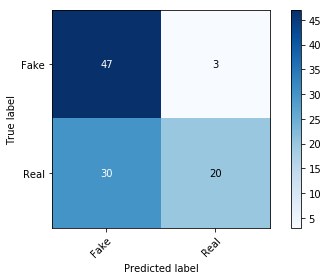


=============== FOLD: 1 =============================
Prediction dist


False    0.8
True     0.2
dtype: float64

TRAIN ACCURACY: 0.933
TRAIN MAP: 0.994
TEST ACCURACY: 0.620
TEST MAP: 0.748


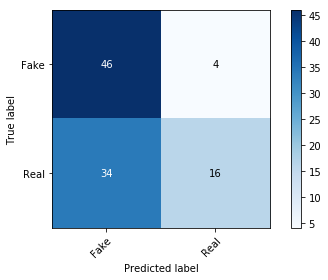


=============== FOLD: 2 =============================
Prediction dist


False    0.75
True     0.25
dtype: float64

TRAIN ACCURACY: 0.930
TRAIN MAP: 0.994
TEST ACCURACY: 0.590
TEST MAP: 0.682


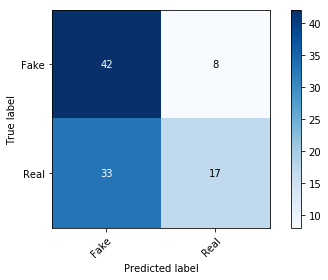


=============== FOLD: 3 =============================
Prediction dist


False    0.69
True     0.31
dtype: float64

TRAIN ACCURACY: 0.930
TRAIN MAP: 0.993
TEST ACCURACY: 0.650
TEST MAP: 0.777


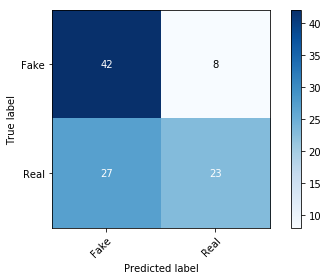


=============== FOLD: 4 =============================
Prediction dist


False    0.66
True     0.34
dtype: float64

TRAIN ACCURACY: 0.931
TRAIN MAP: 0.994
TEST ACCURACY: 0.660
TEST MAP: 0.753


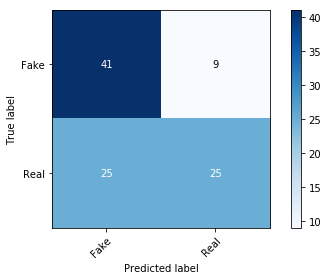


=============== FOLD: 5 =============================
Prediction dist


False    0.73
True     0.27
dtype: float64

TRAIN ACCURACY: 0.936
TRAIN MAP: 0.994
TEST ACCURACY: 0.650
TEST MAP: 0.733


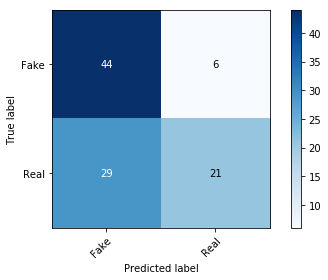


=============== FOLD: 6 =============================
Prediction dist


False    0.74
True     0.26
dtype: float64

TRAIN ACCURACY: 0.934
TRAIN MAP: 0.994
TEST ACCURACY: 0.660
TEST MAP: 0.764


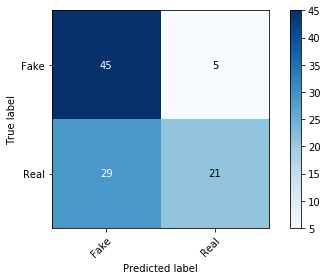


=============== FOLD: 7 =============================
Prediction dist


False    0.74
True     0.26
dtype: float64

TRAIN ACCURACY: 0.934
TRAIN MAP: 0.994
TEST ACCURACY: 0.580
TEST MAP: 0.684


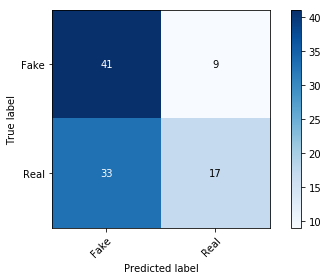


=============== FOLD: 8 =============================
Prediction dist


False    0.74
True     0.26
dtype: float64

TRAIN ACCURACY: 0.932
TRAIN MAP: 0.993
TEST ACCURACY: 0.640
TEST MAP: 0.737


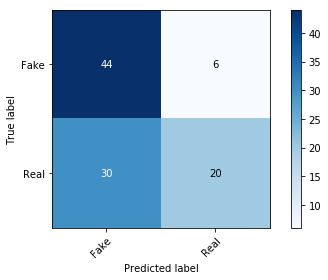


=============== FOLD: 9 =============================
Prediction dist


False    0.74
True     0.26
dtype: float64

TRAIN ACCURACY: 0.936
TRAIN MAP: 0.994
TEST ACCURACY: 0.600
TEST MAP: 0.620


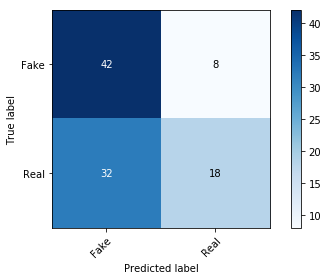

train_accs  test_accs  train_map   test_map
count   10.000000  10.000000  10.000000  10.000000
mean     0.932934   0.632000   0.993716   0.730132
std      0.002384   0.032249   0.000478   0.054272
min      0.929889   0.580000   0.992681   0.619956
25%      0.931042   0.605000   0.993580   0.695804
50%      0.933118   0.645000   0.993801   0.742463
75%      0.934271   0.657500   0.993928   0.761082
max      0.936347   0.670000   0.994372   0.805024

In [155]:
train_accs = []
test_accs = []
train_map = []
test_map = []

train_f1s = []
test_f1s = []

print('Cross validation...')
for i, (X_train, y_train, X_test, y_test) in enumerate(splits):
    print()
    print('=============== FOLD: {} ============================='.format(i))
    #pipeline = Pipeline(steps)
    pipeline = meta_clf
    #weights = ((len(X_train) - len(df_reuters)) * [1]) + (len(df_reuters) * [0.5])
    # clf__sample_weight=weights
    pipeline.fit(X_train, y_train)
    
#     if i == 0:
#         print('Vocabulary size: {}'.format(
#             len(pipeline.named_steps.union.transformer_list[0][1].steps[1][1].vocabulary_)))
    

    pred = pipeline.predict(X_test)
    
    print('Prediction dist')
    display(pd.Series(pred).value_counts(normalize=True))

    pred_train = pipeline.predict(X_train)
    train_acc = accuracy_score(y_train, pred_train)
    train_accs.append(train_acc)
    print('TRAIN ACCURACY: {0:.3f}'.format(train_acc))
    #train_f1 = f1_score(y_train, pred_train)
    #print('TRAIN F1: {0:.3f}'.format(train_f1))
    #train_f1s.append(train_f1)
    
    y_scores = pipeline.predict_proba(X_train)[:,1]
    mean_prec = average_precision_score(y_train, y_scores)
    train_map.append(mean_prec)
    print('TRAIN MAP: {0:.3f}'.format(mean_prec))
    
    test_acc = accuracy_score(y_test, pred)
    test_accs.append(round(test_acc, 2))
    print('TEST ACCURACY: {0:.3f}'.format(test_acc))
#     test_f1 = f1_score(y_test, pred)
#     print('TEST F1: {0:.3f}'.format(test_f1))
#     test_f1s.append(test_f1)
    
    y_scores = pipeline.predict_proba(X_test)[:,1]
    mean_prec = average_precision_score(y_test, y_scores)
    test_map.append(mean_prec)
    print('TEST MAP: {0:.3f}'.format(mean_prec))
    
    
    plot_confusion_matrix(y_test, pred)
    plt.show()
    
    #.toarray()
    
   # coef = pipeline.named_steps.clf.feature_importances_
#     coef = pipeline.named_steps.clf.coef_.toarray().reshape(-1)
#     f_names = get_feature_names(pipeline)
#     f_importances(coef, f_names, n=20)
#     new_d = 
#     all_imp = { k: x.get(k, 0) + y.get(k, 0) for k in set(x) | set(y) }
#     all_imp.append(dict(zip(coef, f_names)))
    
results = pd.DataFrame()
results['train_accs'] = train_accs
results['test_accs'] = test_accs
results['train_map'] = train_map
results['test_map'] = test_map
results.describe()

In [425]:
results.describe()

train_accs  test_accs  train_map   test_map
count        10.0  10.000000       10.0  10.000000
mean          1.0   0.617000        1.0   0.736000
std           0.0   0.042177        0.0   0.060406
min           1.0   0.530000        1.0   0.630000
25%           1.0   0.597500        1.0   0.692500
50%           1.0   0.625000        1.0   0.770000
75%           1.0   0.647500        1.0   0.777500
max           1.0   0.660000        1.0   0.780000

In [39]:
def plot_confusion_matrix(y_true, y_pred, classes=['Fake', 'Real'],
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     if not title:
#         if normalize:
#             title = 'Normalized confusion matrix'
#         else:
#             title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax